In [16]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.linalg import norm
from sklearn.metrics import silhouette_samples
np.set_printoptions(threshold=sys.maxsize)

## Preprocessing the data before clustering

In [17]:
dataset = pd.read_csv('../football_data.csv')

In [18]:
toKeep = np.array([3, 7, 8, 11, 12, 13, 15, 16, 17, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88])
X = dataset.iloc[:,toKeep].values
header = dataset.iloc[:,toKeep].columns

print("Getting the data and headers.")
print("Shape of new data:", X.shape)

row_length = X.shape[0]
col_length = X.shape[1]
# print(row_length)
# print(col_length)

overview_value_wage_arr = [3,4,X.shape[1]-1]
overview_value_wage_arr = np.array(overview_value_wage_arr)

'''
Removing Euro, Million, and K sign from wage and values
'''
print("Removing Euro, Million, and K sign from wage and values.")
for j in overview_value_wage_arr:
    for i in range(row_length):
        if type(X[i,j]) is not float:
            last_char = X[i,j][-1]
            if last_char == 'M':
                X[i,j] = 1000000*float(X[i,j][1:-1])
            elif last_char == 'K':
                X[i,j] = 1000*float(X[i,j][1:-1])
            else:
                X[i,j]=0

'''
Extracting year from date
'''
print("Extracting year from date.")
for j in range(10,12):
    for i in range(row_length):
        if type(X[i,j]) is not float:
            year = X[i,j][-4:]
            year = float(year)
            X[i,j] = year

'''
Getting height in inches
'''
print("Getting height in inches.")
for i in range (row_length):
    if type(X[i,12]) is not float:
        hh = X[i,12].split("'")
        ft = float(hh[0])
        ich = float(hh[1])
        ich = ich + 12*ft
        float(ich)
        X[i,12]=ich
      
'''
Extracting weight value by removing "lbs"
'''
print("Extracting weight value by removing lbs.")
for i in range(X.shape[0]):
    if type(X[i,13]) is not float:
        wgt = X[i,13][:-3]
        wgt = float(wgt)
        X[i,13] = wgt
        
'''
Converting all numeric data to float
'''
print("Converting all numeric data to float.")
for i in range(40,col_length-1):
    X[:,i].astype(float)

'''
Removing "+" signs if any
'''
print("Removing + signs if any.")
for j in range(14,40):
    for i in range (row_length):
        if type(X[i,j]) is not float:
            hh = X[i,j].split("+")
            fv = float(hh[0])
            sv = float(hh[1])
            X[i,j]=fv+sv

X=X.astype(float)

'''
Replacing missing values (if any) by mean for each column
'''
print("Replacing missing values (if any) by mean for each column.")
import sklearn.impute
impobj = sklearn.impute.SimpleImputer(missing_values = np.nan, strategy = 'mean') 
for j in range(col_length):
    imppbj = impobj.fit(X[:, j:j+1])
    X[:, j:j+1] = impobj.transform(X[:, j:j+1])

'''
Standardize features by removing the mean and scaling to unit variance
'''
print("Standardize features by removing the mean and scaling to unit variance.")
import sklearn.preprocessing
X_std = sklearn.preprocessing.StandardScaler().fit_transform(X)

'''
Verifying that mean=0 and variance=1 for each attribute 
'''
print("Tabluating mean and variance to verify that mean=0 and variance=1 for each attribute:")
from prettytable import PrettyTable
t_tab = PrettyTable(['Column Number', 'Mean', 'Variance'])
for i in range(col_length):
    cc = X_std[:,i]
    t_tab.add_row([i+1, np.average(np.array(cc)).round(5), np.var(np.array(cc)).round(5)])
kkkkkk = X_std
print(t_tab)

Getting the data and headers.
Shape of new data: (18207, 75)
Removing Euro, Million, and K sign from wage and values.
Extracting year from date.
Getting height in inches.
Extracting weight value by removing lbs.
Converting all numeric data to float.
Removing + signs if any.
Replacing missing values (if any) by mean for each column.
Standardize features by removing the mean and scaling to unit variance.
Tabluating mean and variance to verify that mean=0 and variance=1 for each attribute:
+---------------+------+----------+
| Column Number | Mean | Variance |
+---------------+------+----------+
|       1       | 0.0  |   1.0    |
|       2       | 0.0  |   1.0    |
|       3       | 0.0  |   1.0    |
|       4       | -0.0 |   1.0    |
|       5       | 0.0  |   1.0    |
|       6       | -0.0 |   1.0    |
|       7       | -0.0 |   1.0    |
|       8       | -0.0 |   1.0    |
|       9       | -0.0 |   1.0    |
|       10      | -0.0 |   1.0    |
|       11      | -0.0 |   1.0    |
|   

## Kmeans Algorithm

In [27]:
class Kmeans:

    def __init__(self, n_clusters, max_iter=100, random_state=np.random.randint(0, 1000, size=1)):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state


    def comp_centroids(self, X, labels):
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            
            '''
            calculating mean to get new  centroids
            '''
         
            centroids[k, :] = np.mean(X[labels == k, :], axis=0)
        return centroids
    
 
    def comp_distance(self, X, centroids):
        '''
        initializing distance matrix
        '''
        distance = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            '''
            calculating distance for each point from k 
            '''
            arr = X - centroids[k,:]
            row_norm = norm(arr, axis=1)
            distance[:, k] = np.square(row_norm)
        return distance
    

    
    def fit(self, X):
        np.random.RandomState(self.random_state)
        '''
        randomising all examples in the dataset
        '''
        random_idx = np.random.permutation(X.shape[0])
        '''
        choosing n_clusters points as random centroids initially 
        '''
        self.centroids = X[random_idx[:self.n_clusters]]
        
        
       
        '''
        KMEANS ITERATIONS 
        '''
        for i in range(self.max_iter):
            o_centroids = self.centroids
            '''
            calculating the distance of every datapoint from each centroid 
            and finding closest centroid for all points
            '''
            distance = self.comp_distance(X, o_centroids)
            self.labels = np.argmin(distance, axis=1)
            self.centroids = self.comp_centroids(X, self.labels)
            '''
            If all centroids remain same then Kmeans is over
            '''
            if np.all(o_centroids == self.centroids):
                break
        '''
        calculating SSE (sum of squared error) for centroids
        '''
        dd = np.zeros(X.shape[0])
        for k in range(self.n_clusters):
        
            '''
            Finding distance of each point from mean to find data distribution
            '''
        
            dd[self.labels == k] = norm(X[self.labels == k] - self.centroids[k], axis=1)
        self.error = np.sum(np.square(dd))

    
    
    def predict(self, X):
        distance = self.comp_distance(X, self.centroids)
        return np.argmin(distance, axis=1)


## Plotting the graphs

### Here we tried to test kmeans by running it multiple times with different initial centroid just to be sure that we are not getting trapped in some bias present in the data


In [34]:
given_k = [3,5,7]
for l,j in enumerate(given_k):
    print(l,j)
clist = ['green','blue','orange','pink','yellow','grey','indigo']
llist = ['cluster 1','cluster 2','cluster 3','cluster 4','cluster 5','cluster 6','cluster 7']

0 3
1 5
2 7


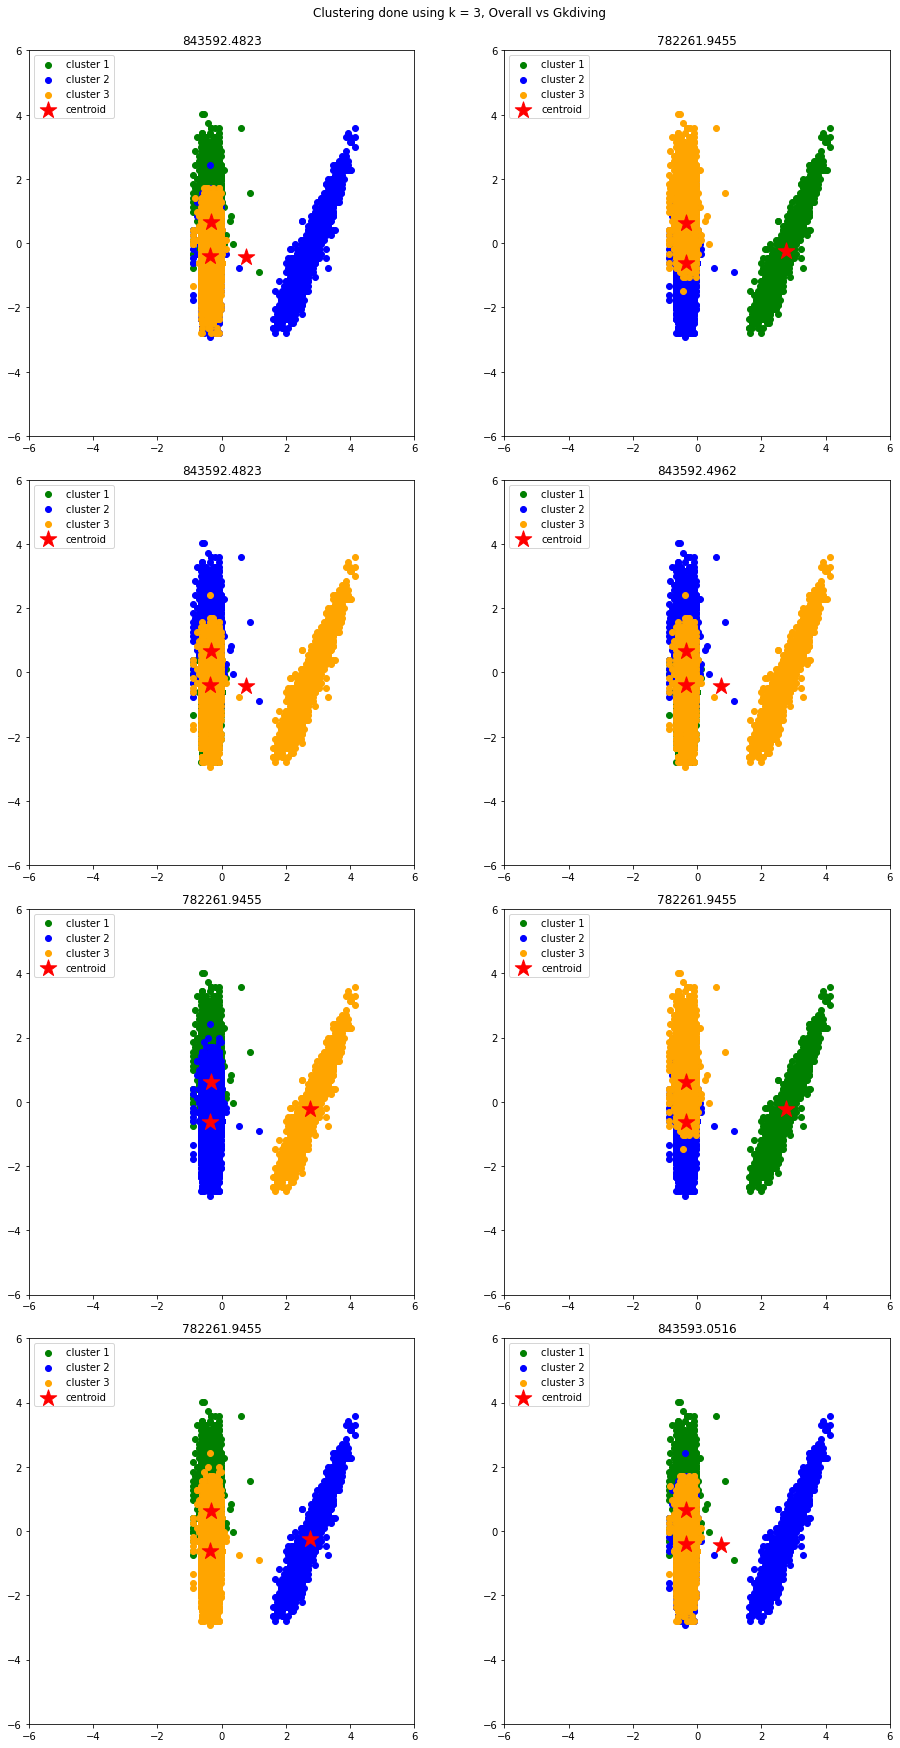

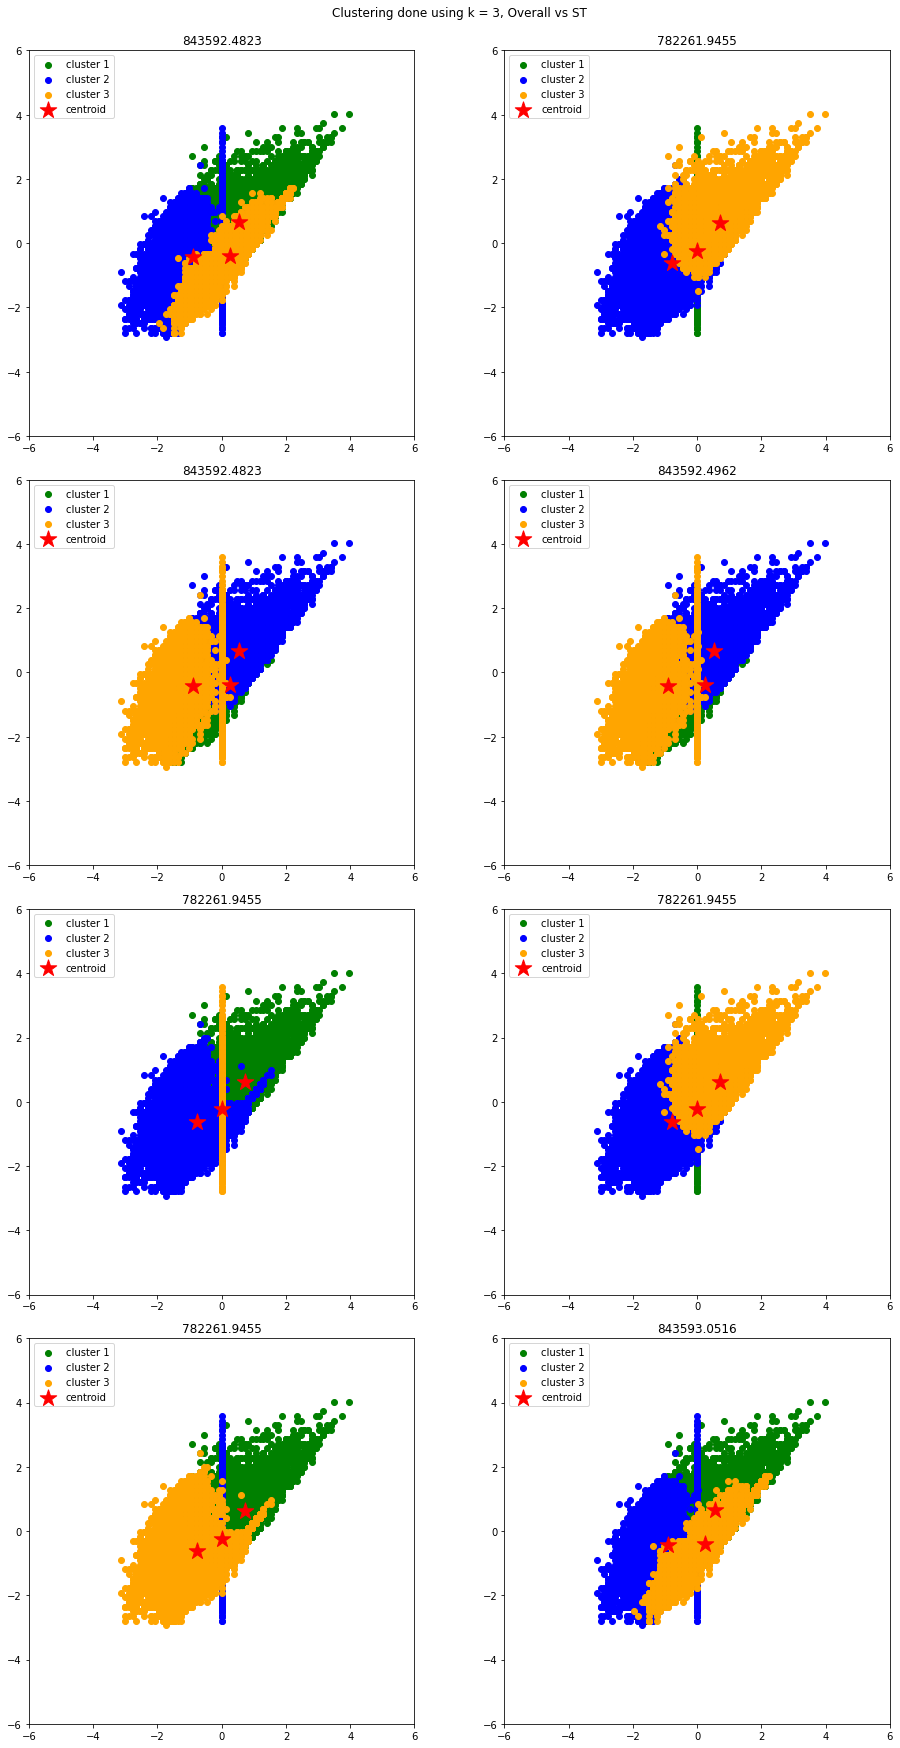

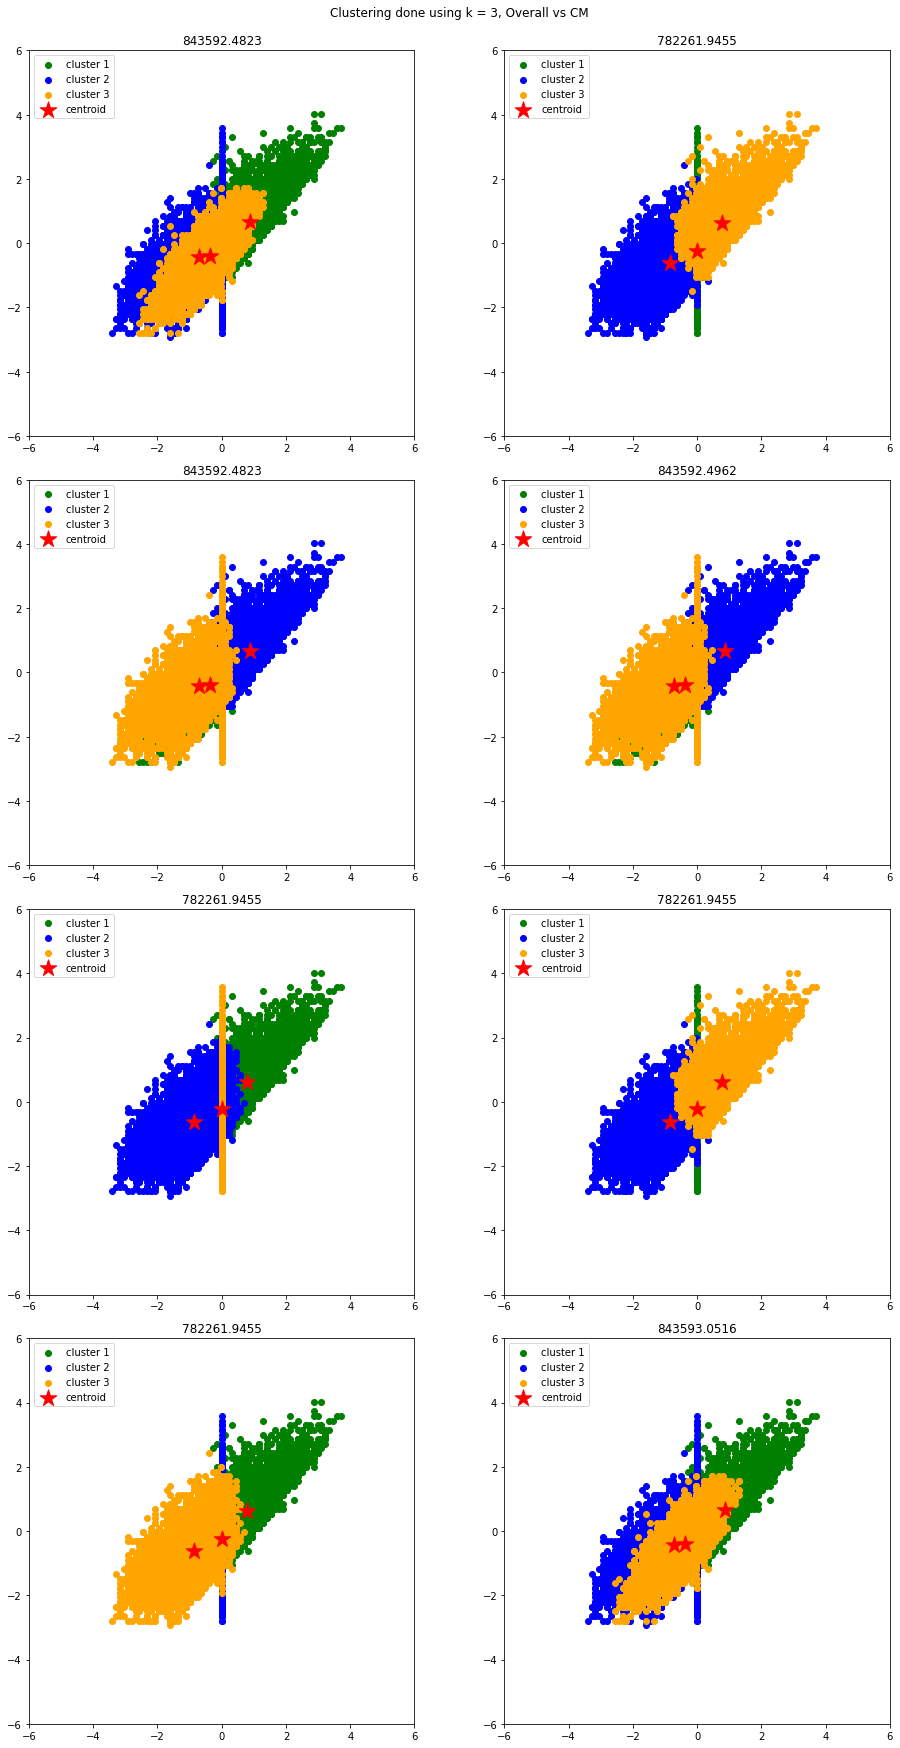

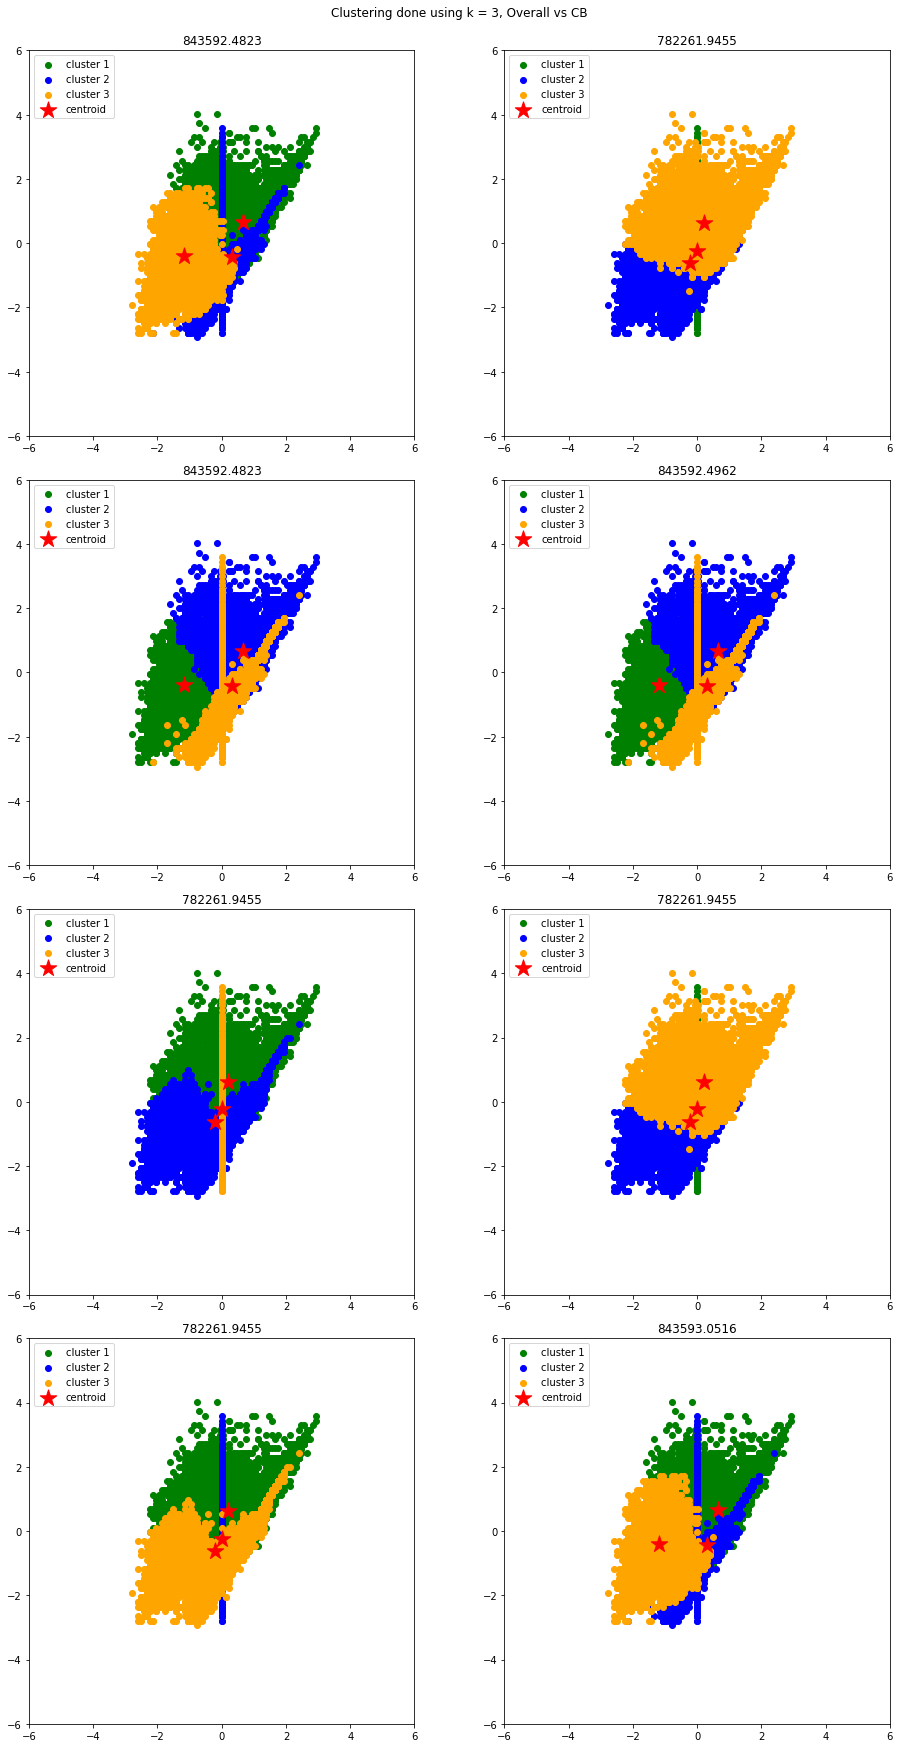

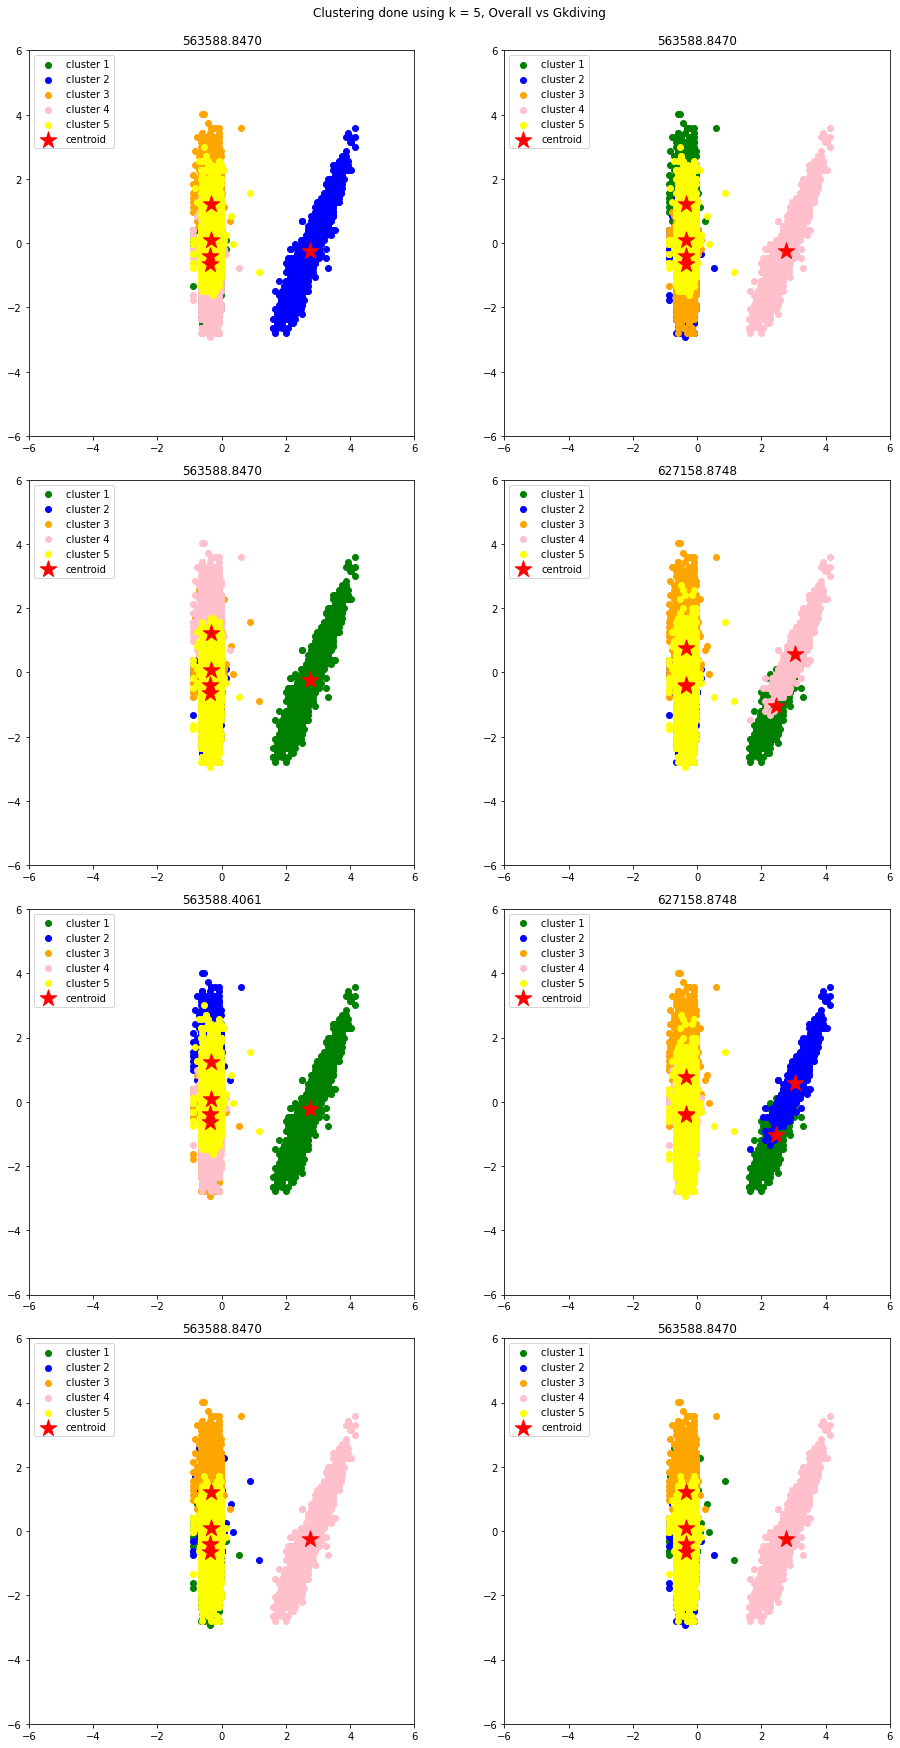

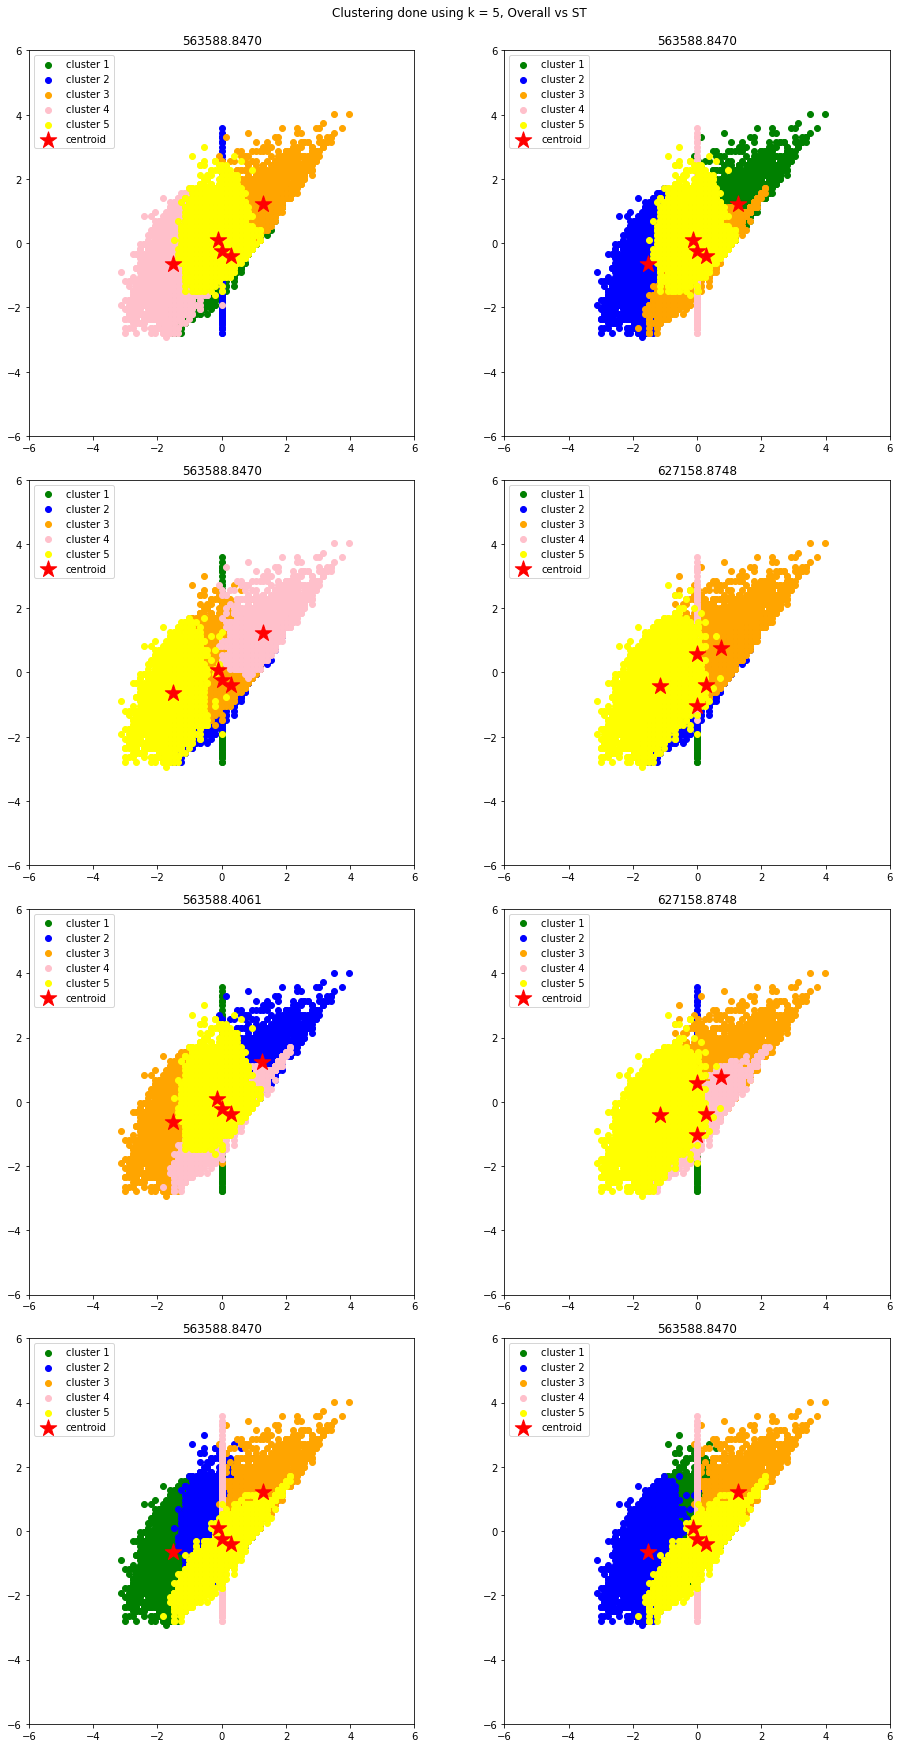

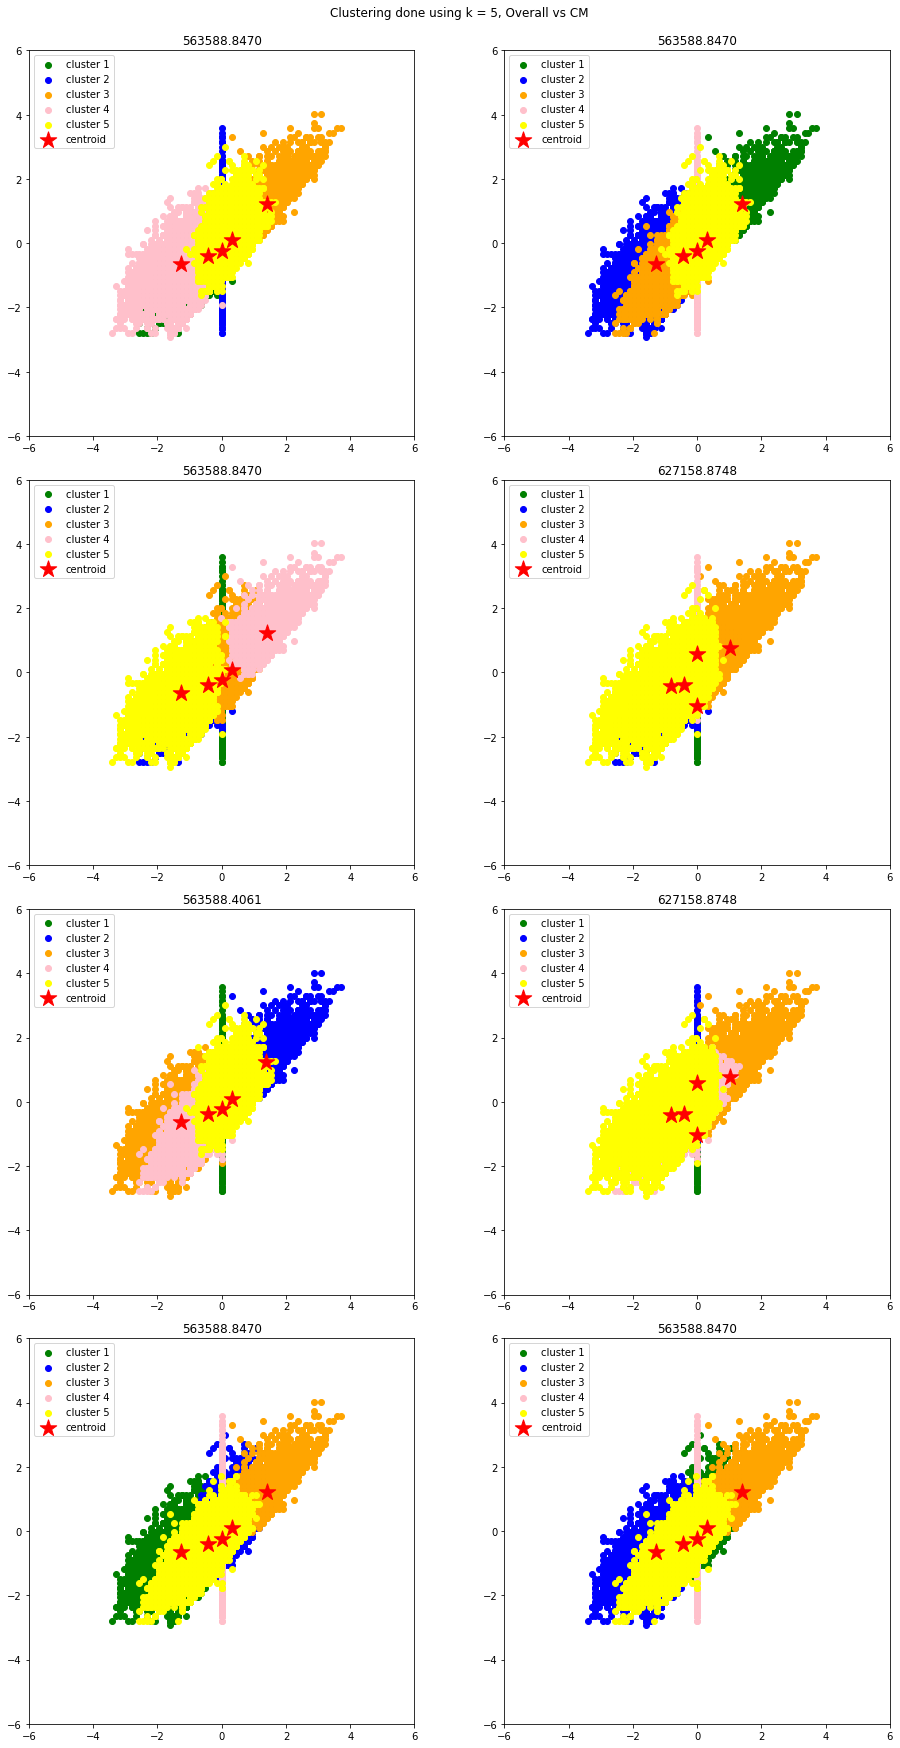

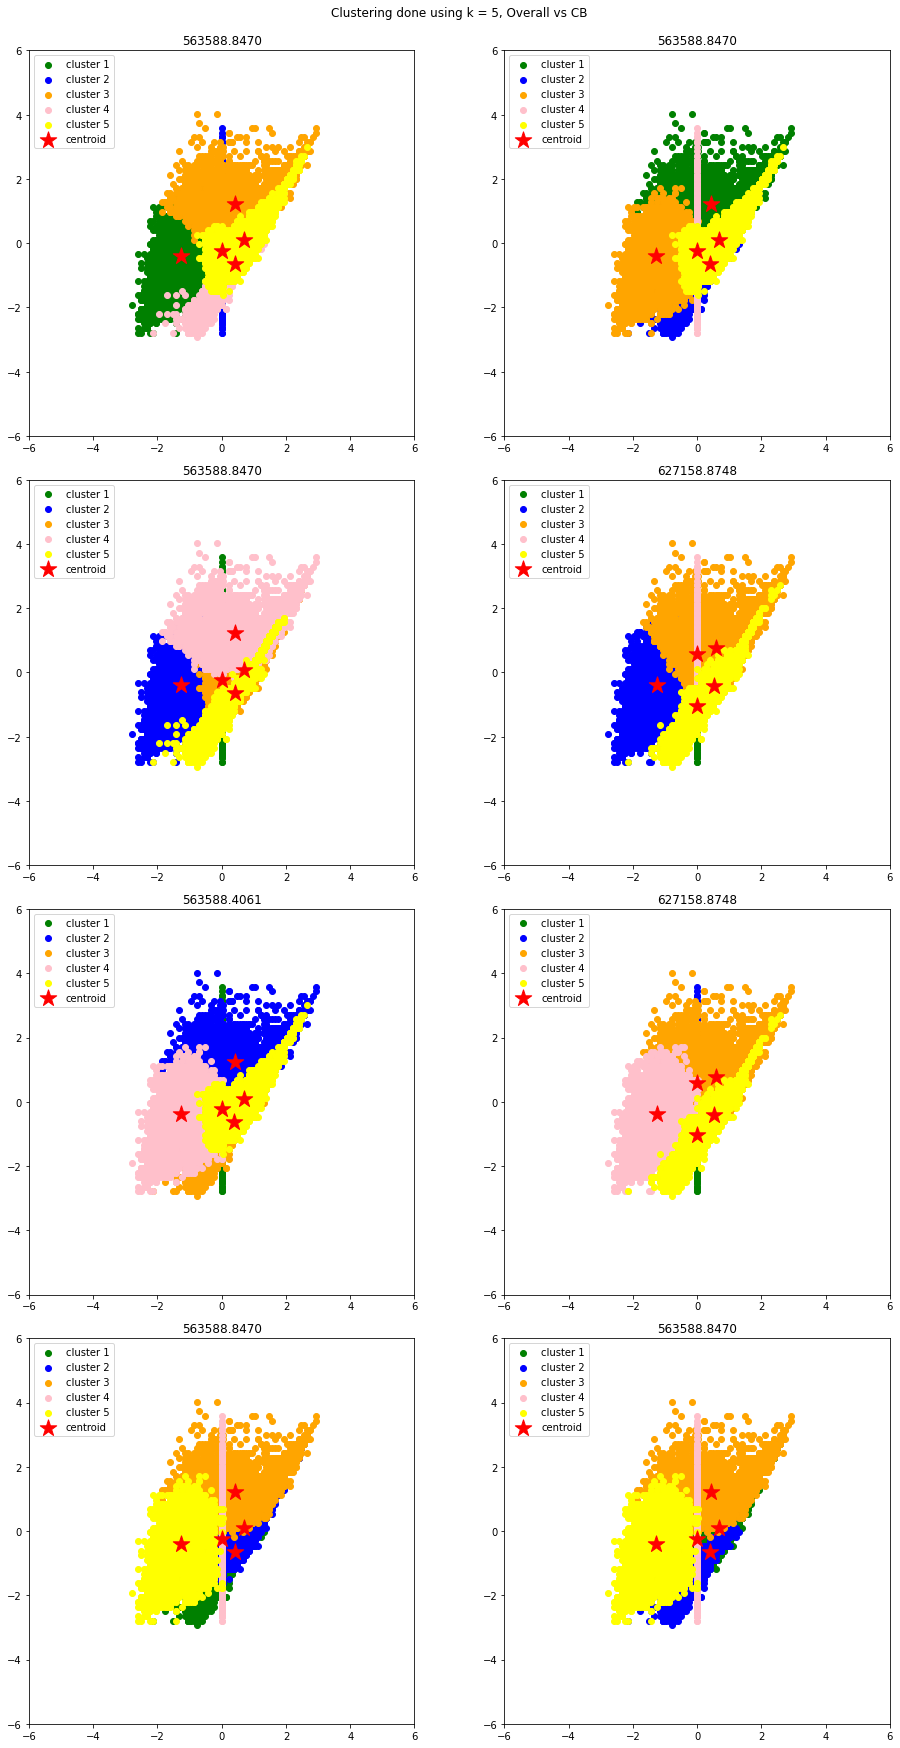

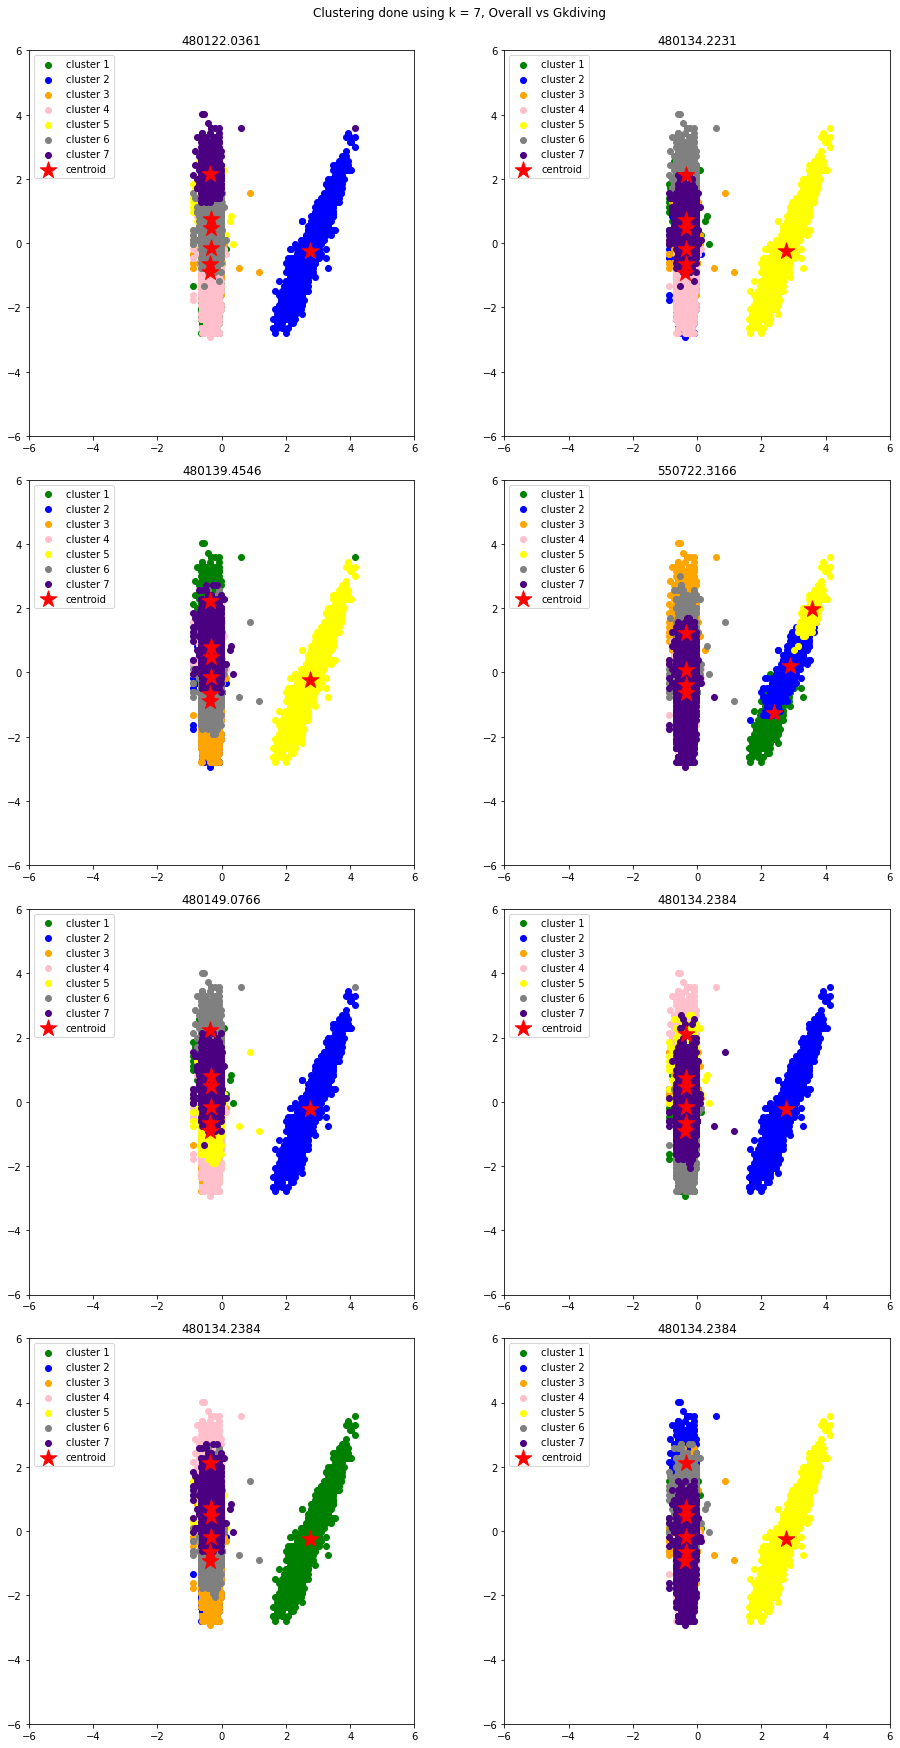

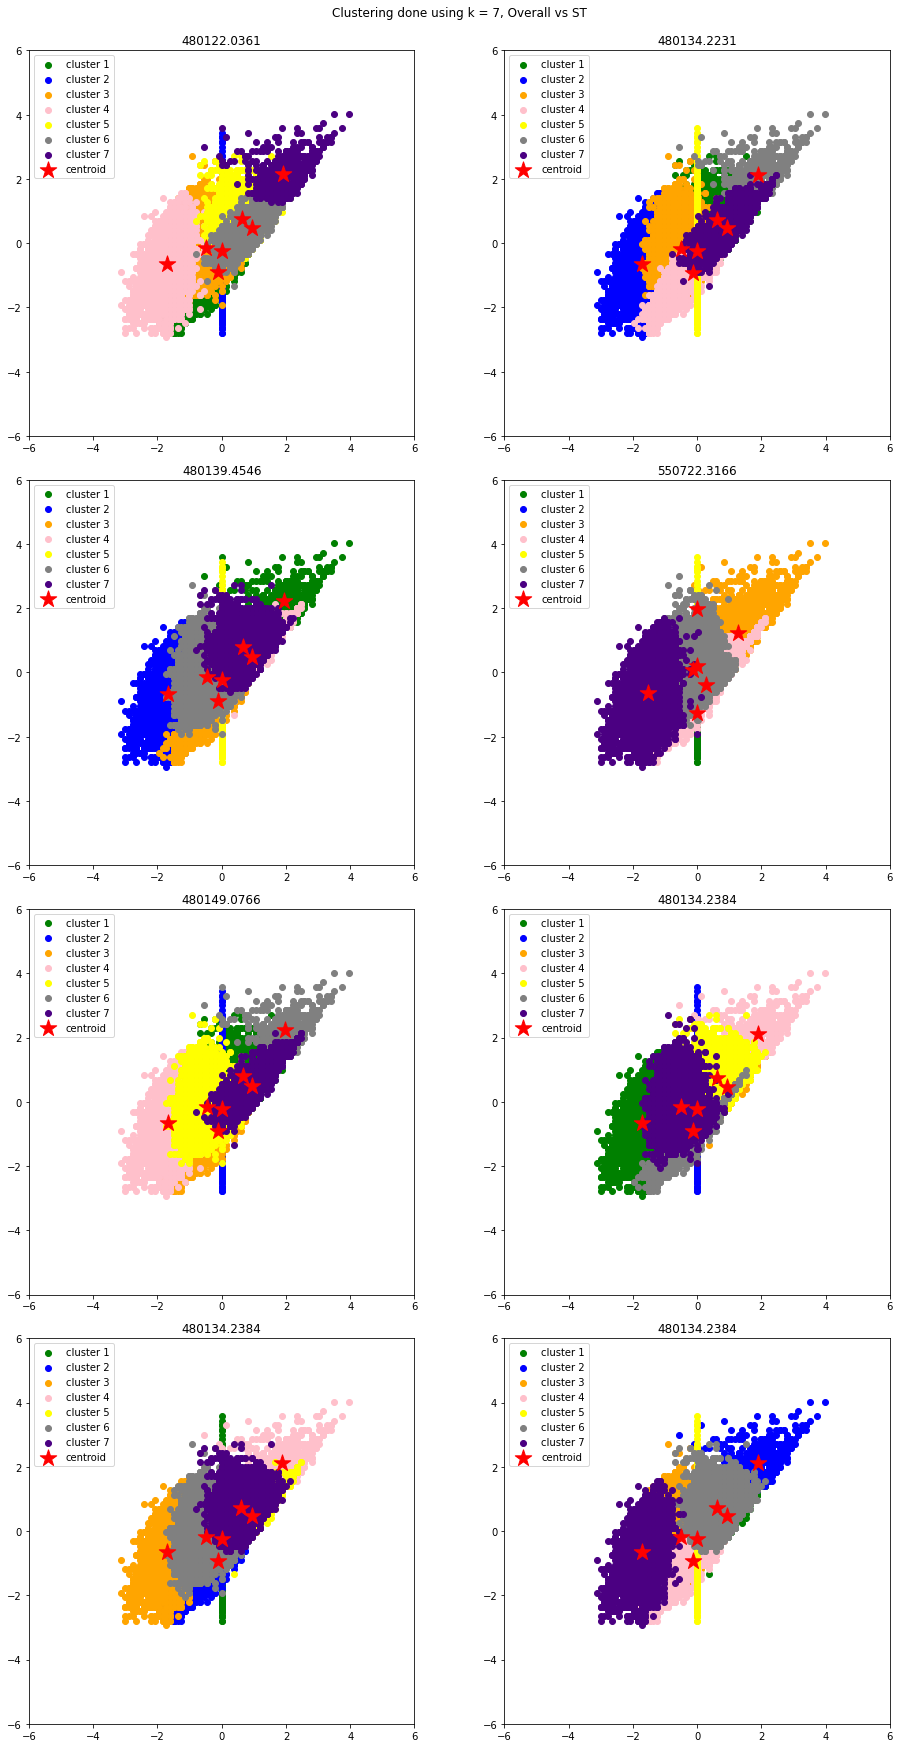

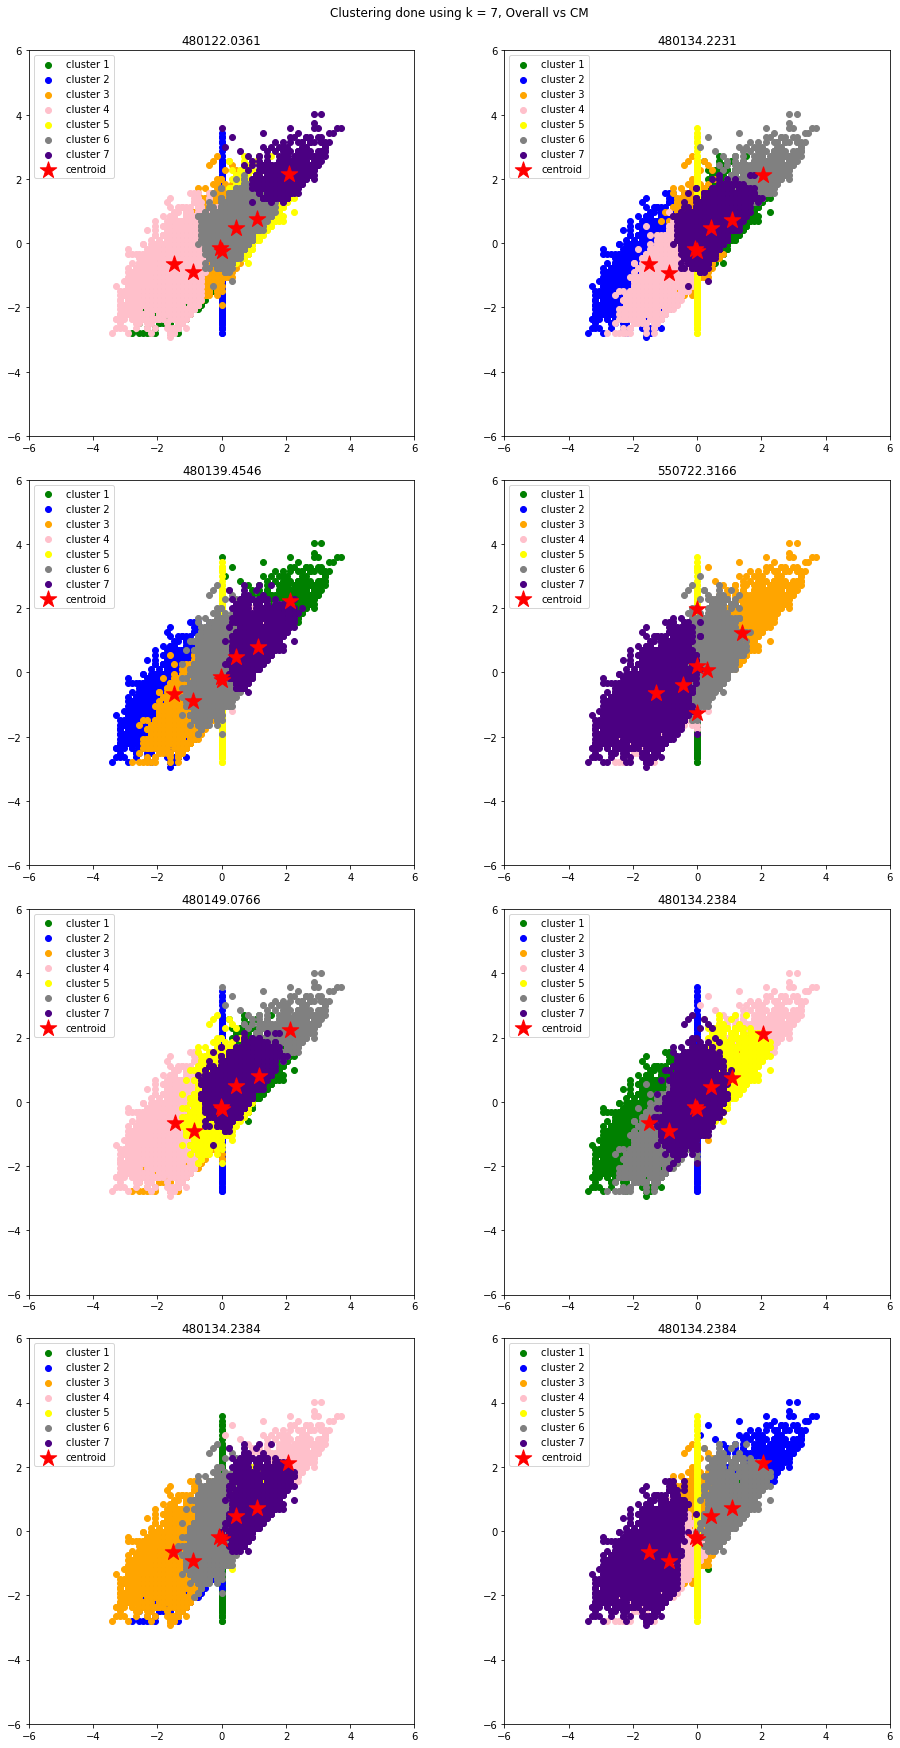

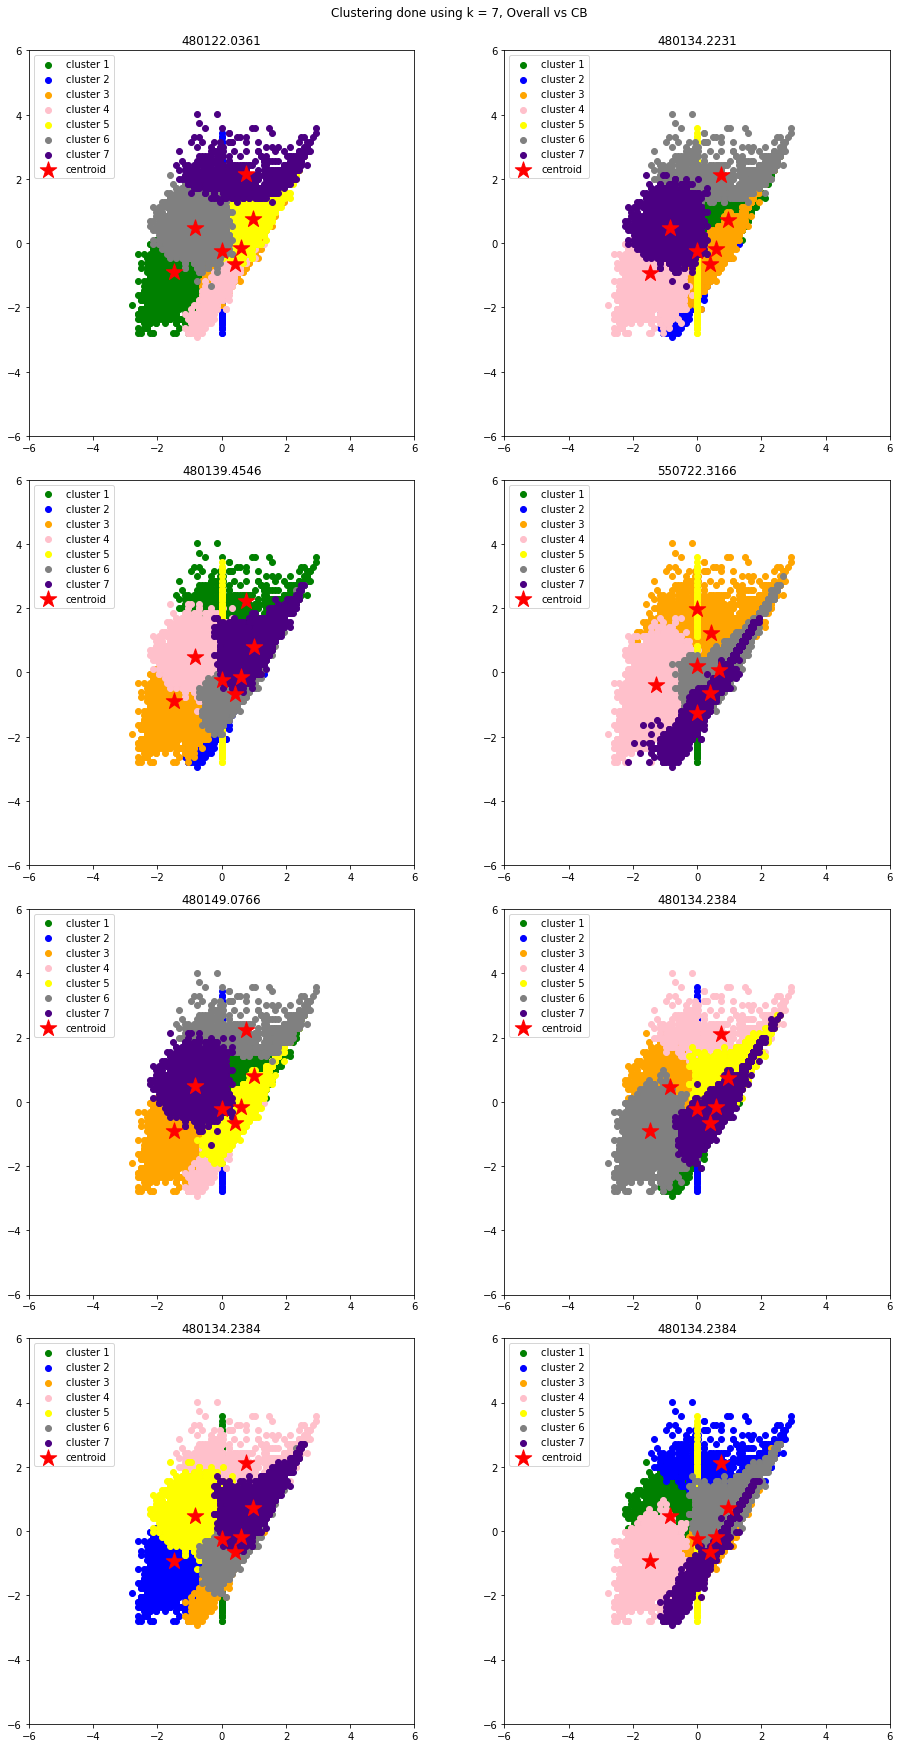

In [40]:
given_k = [3,5,7]
for l,j in enumerate(given_k): 
    fig, ax = plt.subplots(4, 2, figsize=(14, 24))
    fig1, ay = plt.subplots(4, 2, figsize=(14, 24))
    fig2, az = plt.subplots(4, 2, figsize=(14, 24))
    fig3, au = plt.subplots(4, 2, figsize=(14, 24))
    ax = np.ravel(ax)
    ay = np.ravel(ay)
    az = np.ravel(az)
    au = np.ravel(au)
    
    for i in range(8):
        km = Kmeans(n_clusters=j)
        km.fit(X_std)
        centroids = km.centroids
        
        ''' Graph : Overall vs Gkdiving  '''
        
        ax[i].scatter(X_std[km.labels == 0, 69], X_std[km.labels == 0, 1], c=clist[0], label=llist[0])
        ax[i].scatter(X_std[km.labels == 1, 69], X_std[km.labels == 1, 1], c=clist[1], label=llist[1])
        ax[i].scatter(X_std[km.labels == 2, 69], X_std[km.labels == 2, 1], c=clist[2], label=llist[2])
        if j > 3:
            ax[i].scatter(X_std[km.labels == 3, 69], X_std[km.labels == 3, 1], c=clist[3], label=llist[3])
            ax[i].scatter(X_std[km.labels == 4, 69], X_std[km.labels == 4, 1], c=clist[4], label=llist[4])
        
        if j > 5:
            
            ax[i].scatter(X_std[km.labels == 5, 69], X_std[km.labels == 5, 1], c=clist[5], label=llist[5])
            ax[i].scatter(X_std[km.labels == 6, 69], X_std[km.labels == 6, 1], c=clist[6], label=llist[6])

        ax[i].scatter(centroids[:, 69], centroids[:, 1], c='red', marker='*', s=300, label='centroid')
        ax[i].set_xlim([-6, 6])
        ax[i].set_ylim([-6, 6])
        ax[i].legend(loc='upper left')
        ax[i].set_title(f'{km.error:.4f}')
        ax[i].set_aspect('equal')
        
        ''' Graph : Overall vs ST '''
        
        ay[i].scatter(X_std[km.labels == 0, 15], X_std[km.labels == 0, 1], c=clist[0], label=llist[0])
        ay[i].scatter(X_std[km.labels == 1, 15], X_std[km.labels == 1, 1], c=clist[1], label=llist[1])
        ay[i].scatter(X_std[km.labels == 2, 15], X_std[km.labels == 2, 1], c=clist[2], label=llist[2])
        if j > 3:
            ay[i].scatter(X_std[km.labels == 3, 15], X_std[km.labels == 3, 1], c=clist[3], label=llist[3])
            ay[i].scatter(X_std[km.labels == 4, 15], X_std[km.labels == 4, 1], c=clist[4], label=llist[4])
        
        if j > 5:
           
            ay[i].scatter(X_std[km.labels == 5, 15], X_std[km.labels == 5, 1], c=clist[5], label=llist[5])
            ay[i].scatter(X_std[km.labels == 6, 15], X_std[km.labels == 6, 1], c=clist[6], label=llist[6])


        ay[i].scatter(centroids[:, 15], centroids[:, 1], c='red', marker='*', s=300, label='centroid')
        ay[i].set_xlim([-6, 6])
        ay[i].set_ylim([-6, 6])
        ay[i].legend(loc='upper left')
        ay[i].set_title(f'{km.error:.4f}')
        ay[i].set_aspect('equal')
        
        
        ''' Graph : Overall vs CM  '''
        
        az[i].scatter(X_std[km.labels == 0, 27], X_std[km.labels == 0, 1], c=clist[0], label=llist[0])
        az[i].scatter(X_std[km.labels == 1, 27], X_std[km.labels == 1, 1], c=clist[1], label=llist[1])
        az[i].scatter(X_std[km.labels == 2, 27], X_std[km.labels == 2, 1], c=clist[2], label=llist[2])
        if j > 3:
            az[i].scatter(X_std[km.labels == 3, 27], X_std[km.labels == 3, 1], c=clist[3], label=llist[3])
            az[i].scatter(X_std[km.labels == 4, 27], X_std[km.labels == 4, 1], c=clist[4], label=llist[4])
        
        if j > 5:
           
            az[i].scatter(X_std[km.labels == 5, 27], X_std[km.labels == 5, 1], c=clist[5], label=llist[5])
            az[i].scatter(X_std[km.labels == 6, 27], X_std[km.labels == 6, 1], c=clist[6], label=llist[6])


        az[i].scatter(centroids[:, 27], centroids[:, 1], c='red', marker='*', s=300, label='centroid')
        az[i].set_xlim([-6, 6])
        az[i].set_ylim([-6, 6])
        az[i].legend(loc='upper left')
        az[i].set_title(f'{km.error:.4f}')
        az[i].set_aspect('equal')
        
        ''' Graph : Overall vs CB  '''
        
        au[i].scatter(X_std[km.labels == 0, 37], X_std[km.labels == 0, 1], c=clist[0], label=llist[0])
        au[i].scatter(X_std[km.labels == 1, 37], X_std[km.labels == 1, 1], c=clist[1], label=llist[1])
        au[i].scatter(X_std[km.labels == 2, 37], X_std[km.labels == 2, 1], c=clist[2], label=llist[2])
        if j > 3:
            au[i].scatter(X_std[km.labels == 3, 37], X_std[km.labels == 3, 1], c=clist[3], label=llist[3])
            au[i].scatter(X_std[km.labels == 4, 37], X_std[km.labels == 4, 1], c=clist[4], label=llist[4])
        
        if j > 5:
           
            au[i].scatter(X_std[km.labels == 5, 37], X_std[km.labels == 5, 1], c=clist[5], label=llist[5])
            au[i].scatter(X_std[km.labels == 6, 37], X_std[km.labels == 6, 1], c=clist[6], label=llist[6])


        au[i].scatter(centroids[:, 37], centroids[:, 1], c='red', marker='*', s=300, label='centroid')
        au[i].set_xlim([-6, 6])
        au[i].set_ylim([-6, 6])
        au[i].legend(loc='upper left')
        au[i].set_title(f'{km.error:.4f}')
        au[i].set_aspect('equal')
        
        
    
    fig.tight_layout()
    fig.suptitle(f'Clustering done using k = ' + str(j)+', Overall vs Gkdiving', y=1.01)
    fig1.tight_layout()
    fig1.suptitle(f'Clustering done using k = ' + str(j)+', Overall vs ST',y=1.01 )
    fig2.tight_layout()
    fig2.suptitle(f'Clustering done using k = ' + str(j)+', Overall vs CM',y=1.01 )
    fig3.tight_layout()
    fig3.suptitle(f'Clustering done using k = ' + str(j)+', Overall vs CB', y=1.01)
    
    

### Here one important thing to notice is that lowest sum of squared distance for all the cases i.e Overall vs Gkdiving, Overall vs ST, Overall vs CM and Overall vs CB is going to be same. You might be seeing different clustering in each case but the actual clustering was done using 74 dimensions and these graphs are between two features only. The value which is being printed on top of each graph is the lowest sum of squared distance value that we have obtained by running the Kmeans clustering over 74 dimensions.

### Choosing different initial centroids can change the whole clustering process because some datapoints may favour the inherent bias present in the data and that's why we are running 8 times for each k with so that we might get 8 different graphs (because our initial centroids will be choosen randomly).

### We have to pick the one with the lowest sum of squared distance.

## Elbow Method

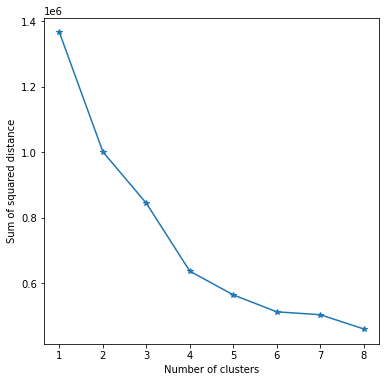

In [53]:
squarederr = []

for i in range(1, 9):
    km = Kmeans(n_clusters=i)
    km.fit(X_std)
    squarederr.append(km.error)
plt.figure(figsize=(6, 6))
plt.plot(list(range(1, 9)), squarederr, '-*')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distance');

### Here best k is 4 because we can see an elbow forming there but it will give different graphs on different run because of the randomly selected initial centroids.

### Elbow method in selecting number of clusters doesn’t usually work because the error function is monotonically decreasing for all ks.

## Silhoutte Analysis

For n_clusters = 2 The average silhouette_score is : 0.24116075877282872
For n_clusters = 3 The average silhouette_score is : 0.21230353113501826
For n_clusters = 4 The average silhouette_score is : 0.27397297161018
For n_clusters = 5 The average silhouette_score is : 0.24763922904319075
For n_clusters = 6 The average silhouette_score is : 0.24157856606287859
For n_clusters = 7 The average silhouette_score is : 0.2287423948448164


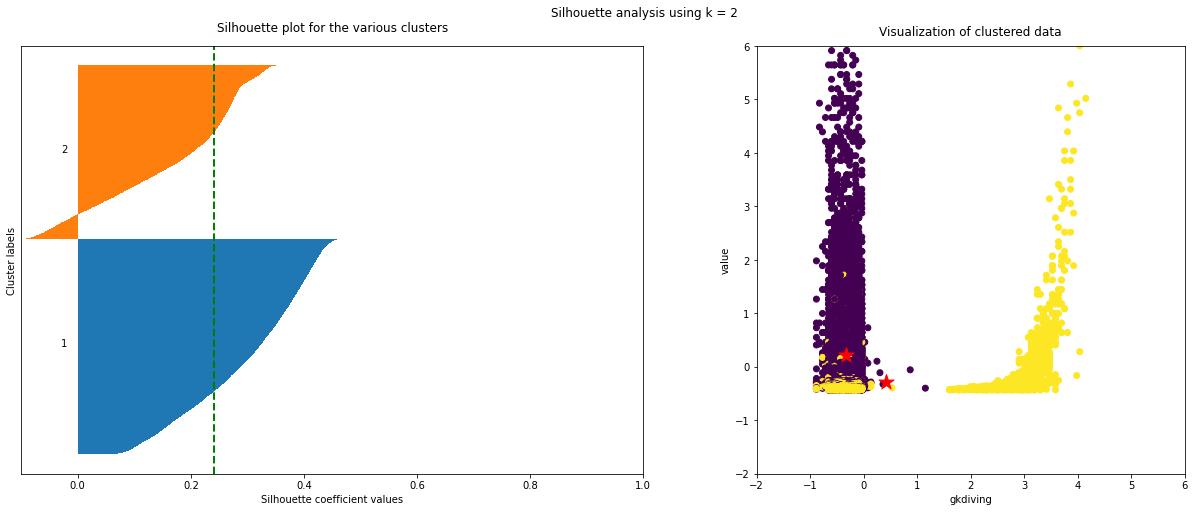

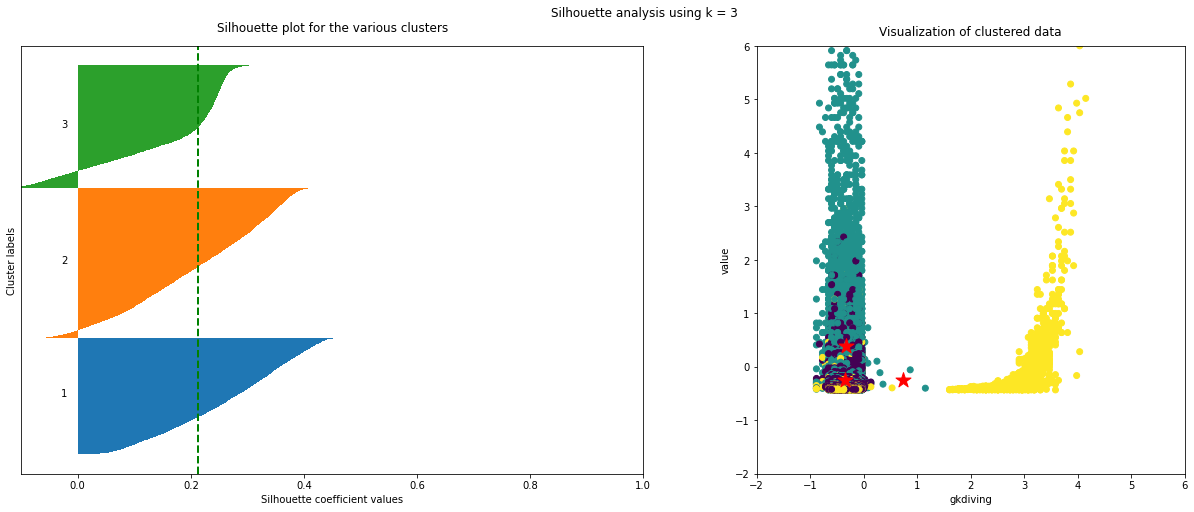

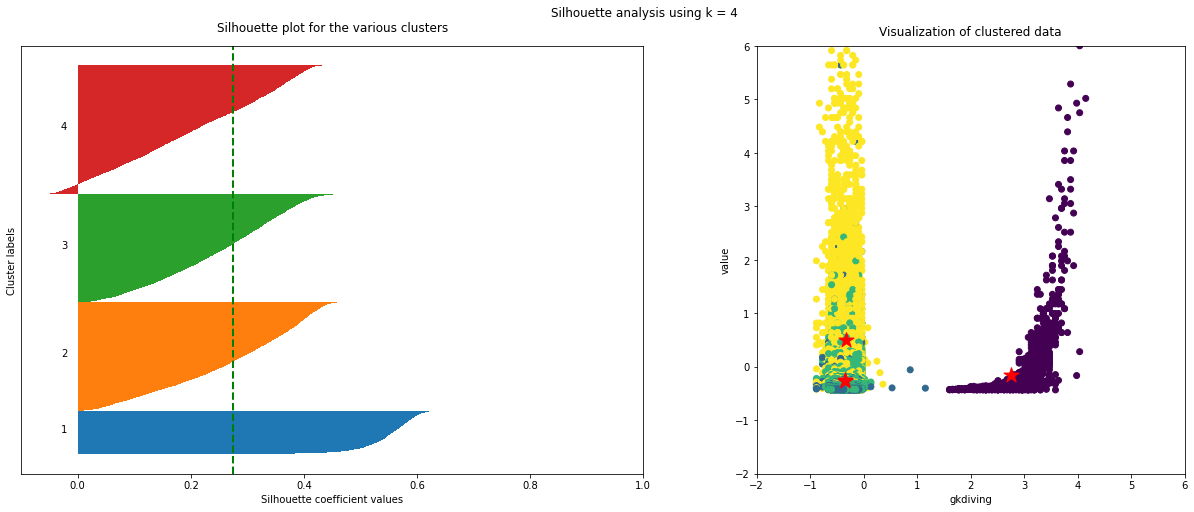

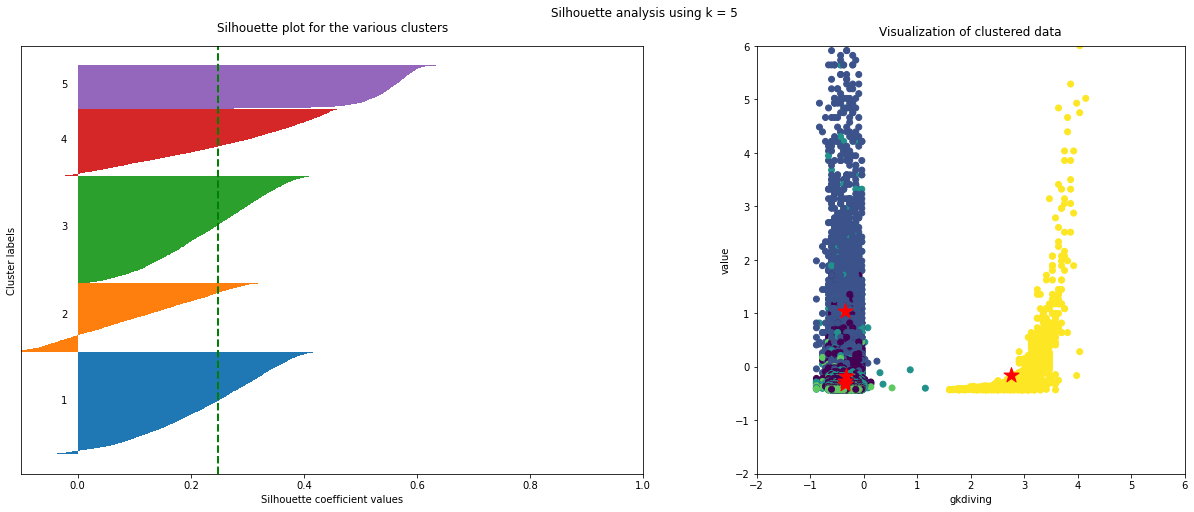

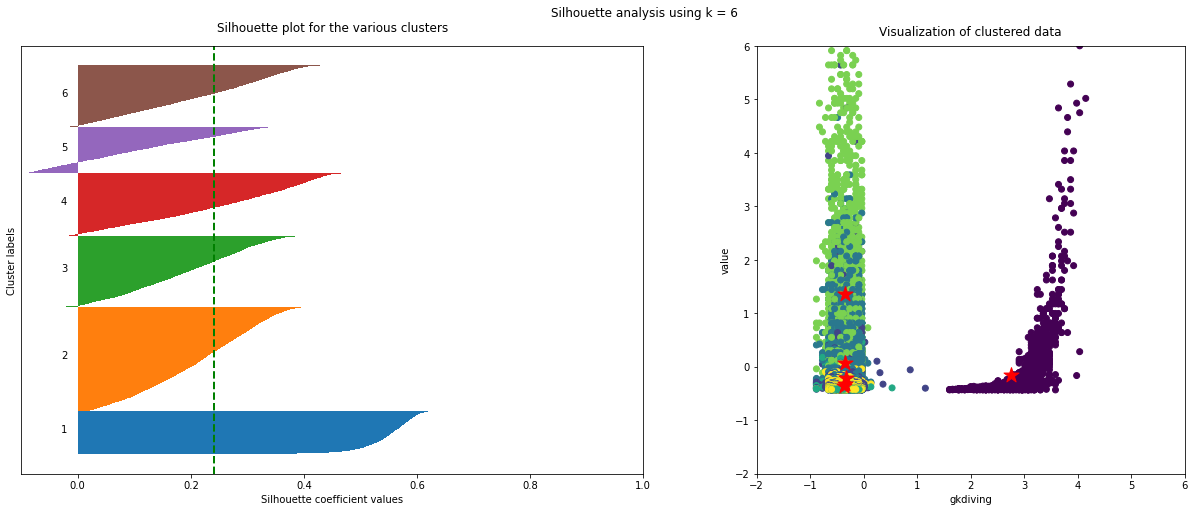

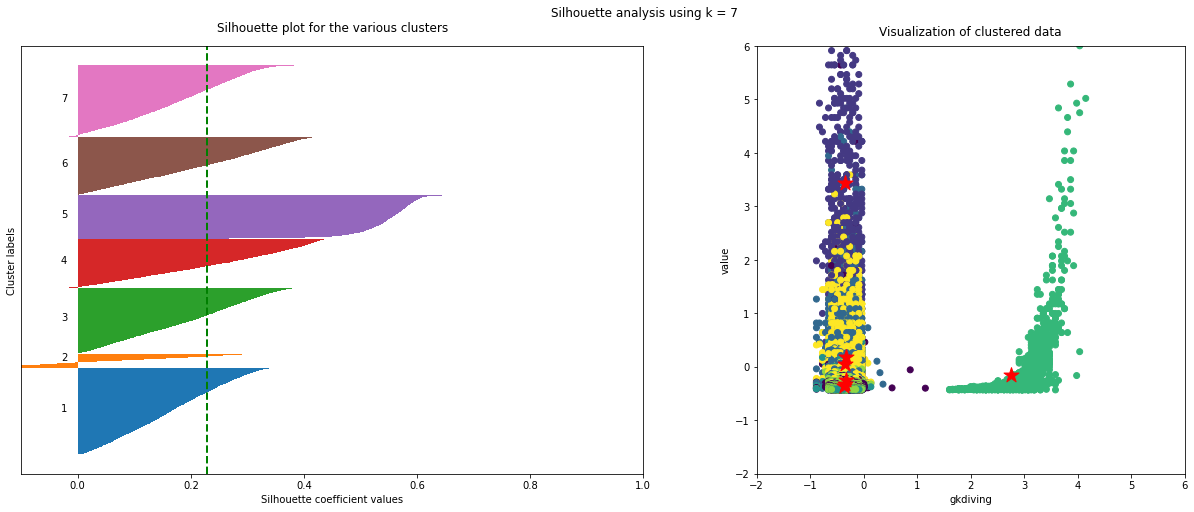

In [54]:
kvals= [2,3,4,5,6,7]
for i, k in enumerate(kvals):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    
    '''
    Run the Kmeans algorithm
    '''
    km = Kmeans(n_clusters=k)
    km.fit(X_std)
    labels = km.predict(X_std)
    centroids = km.centroids
    
    ''' Get silhouette samples '''

    silhouette_vals = silhouette_samples(X_std, labels)

    ''' Silhouette plot'''
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper =  y_upper + len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower =  y_lower + len(cluster_silhouette_vals)

    ''' The silhouette_score gives the average value for all the samples.
     This gives a perspective into the density and separation of the formed
     clusters'''
    
    avg_score = np.mean(silhouette_vals)
    
    print("For n_clusters =", k, "The average silhouette_score is :", avg_score)
    
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    '''Scatter plot of data colored with labels'''
    ax2.scatter(X_std[:, 69], X_std[:, 3], c=labels)
    ax2.scatter(centroids[:, 69], centroids[:, 3], marker='*', c='r', s=250)
    ax2.set_xlim([-2, 6])
    ax2.set_ylim([-2, 6])
    ax2.set_xlabel('gkdiving')
    ax2.set_ylabel('value')
    ax2.set_title('Visualization of clustered data', y=1.01)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle('Silhouette analysis using k = ' + str(k), y=1.01)

### Here the silhouette average score for 4 is the lowest so k = 4 are the optimal number of clusters but here, between 3 and 5 sometimes 3 is better and sometimes 5 is better and the reason for that is there is definitely some kind of inherent bias in the data which is dependent on the initial centroids chosen by the algorithm randomly.

### High silhouette average score will be preferred

### Good n_clusters will have well above 0.5 silhouette average score as well as all of the clusters have higher than the average score.

## Important points

###  Kmeans assumes spherical shapes of clusters (with radius equal to the distance between the centroid and the furthest data point) and doesn’t work well when clusters are in different shapes such as elliptical clusters.

###  If there is overlapping between clusters, kmeans doesn’t have an intrinsic measure for uncertainty for the examples belong to the overlapping region in order to determine for which cluster to assign each data point.